In [42]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing, metrics, model_selection, ensemble
from joblib import Parallel, delayed
import dask.array as da
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import cv2
from kneed import KneeLocator

In [9]:
fpath= "abu-airport-1.mat"
mat_dt= loadmat(fpath)

#fp2= "abu-beach-1.mat"
#mat_dt2= loadmat(fp2)

In [10]:
#displaying the keys to understand the structure of the data
mat_dt.keys()

dict_keys(['__header__', '__version__', '__globals__', 'map', 'data'])

In [11]:
#mat_dt2.keys()

In [12]:
de= mat_dt['data']

#displaying the shape and type of [data] to understad uska dimesion and str
dt_shape= de.shape
dt_type= type(de)

dt_shape, dt_type

((100, 100, 205), numpy.ndarray)

In [14]:
#making a csv file

#reshaping the data to a 2D array where each row is a pixel and each column is a spectral band
reshaped_data= de.reshape(-1, de.shape[2])

#converting the reshaped data to a data frame for CSV export
df= pd.DataFrame(reshaped_data)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,641,720,947,1392,1509,1461,1480,1694,1805,1829,...,98,84,103,89,63,85,69,43,21,25
1,646,721,951,1417,1528,1497,1503,1717,1836,1863,...,97,82,100,88,62,81,67,43,20,25
2,677,724,954,1420,1556,1535,1541,1775,1909,1931,...,95,79,98,83,56,77,65,40,19,24
3,677,724,954,1420,1556,1535,1541,1775,1909,1931,...,95,79,98,83,56,77,65,40,19,24
4,659,721,961,1411,1549,1502,1511,1744,1857,1889,...,92,80,96,82,55,80,66,39,19,23


In [15]:
csv_fpath= 'hyperspectral_img_data.csv'

df.to_csv(csv_fpath, index= False)

csv_fpath

'hyperspectral_img_data.csv'

In [16]:
mat_dt

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Mar 23 18:23:02 2017',
 '__version__': '1.0',
 '__globals__': [],
 'map': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'data': array([[[ 641,  720,  947, ...,   43,   21,   25],
         [ 646,  721,  951, ...,   43,   20,   25],
         [ 677,  724,  954, ...,   40,   19,   24],
         ...,
         [ 825,  927, 1255, ...,   61,   24,   32],
         [ 846,  941, 1317, ...,   71,   34,   42],
         [ 836,  947, 1298, ...,   72,   32,   43]],
 
        [[ 624,  698,  945, ...,   44,   23,   26],
         [ 646,  699,  952, ...,   44,   21,   26],
         [ 637,  706,  936, ...,   43,   20,   24],
         ...,
         [ 855,  961, 1284, ...,   64,   29,   32],
         [ 852,  974, 1360, ...,   77,   35,   46],
         [ 818,  

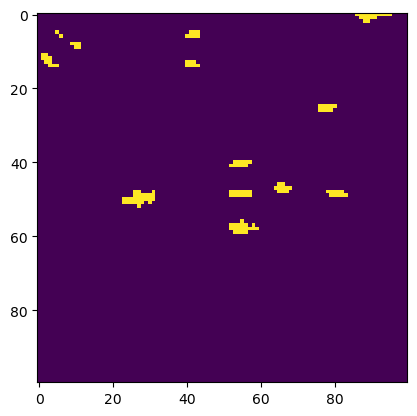

In [18]:
plt.imshow(mat_dt['map'])
plt.show()

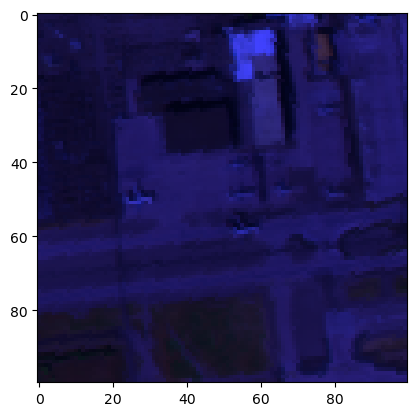

In [21]:
# Select bands for RGB visualization
R_band= mat_dt['data'][:, :, 120] 
G_band= mat_dt['data'][:, :, 60] 
B_band= mat_dt['data'][:, :, 20] 

#stacking the selected bands into a 3D array
RGB_composite = np.stack([R_band, G_band, B_band], axis=-1)

#scaling values to (0, 1) for imshow
RGB_composite_normalized = RGB_composite / RGB_composite.max()

#visualizing the RGB composite
plt.imshow(RGB_composite_normalized)
plt.show()

In [22]:
#making a combined csv file:
map_e= mat_dt['map']

#displaying the shape and type of map for understanding its dimensions and str
map_shape= map_e.shape
map_type= type(map_e)

map_shape, map_type

((100, 100), numpy.ndarray)

In [23]:
#flattening this to align with the reshaped_data
map_flatten= map_e.flatten()

In [24]:
#Combining reshaped data and map flatten into a dataframe
#preparing column names for the df
column_headers= [f'Band_{i+1}' for i in range(reshaped_data.shape[1])] + ['Label']
df2= pd.DataFrame(np.column_stack((reshaped_data, map_flatten)), columns=column_headers)

csv_file_path= 'hyperspectral_combined_data.csv'
df2.to_csv(csv_file_path, index=False)

csv_file_path

'hyperspectral_combined_data.csv'

## NOW WORKING WITH THE MAIN PART

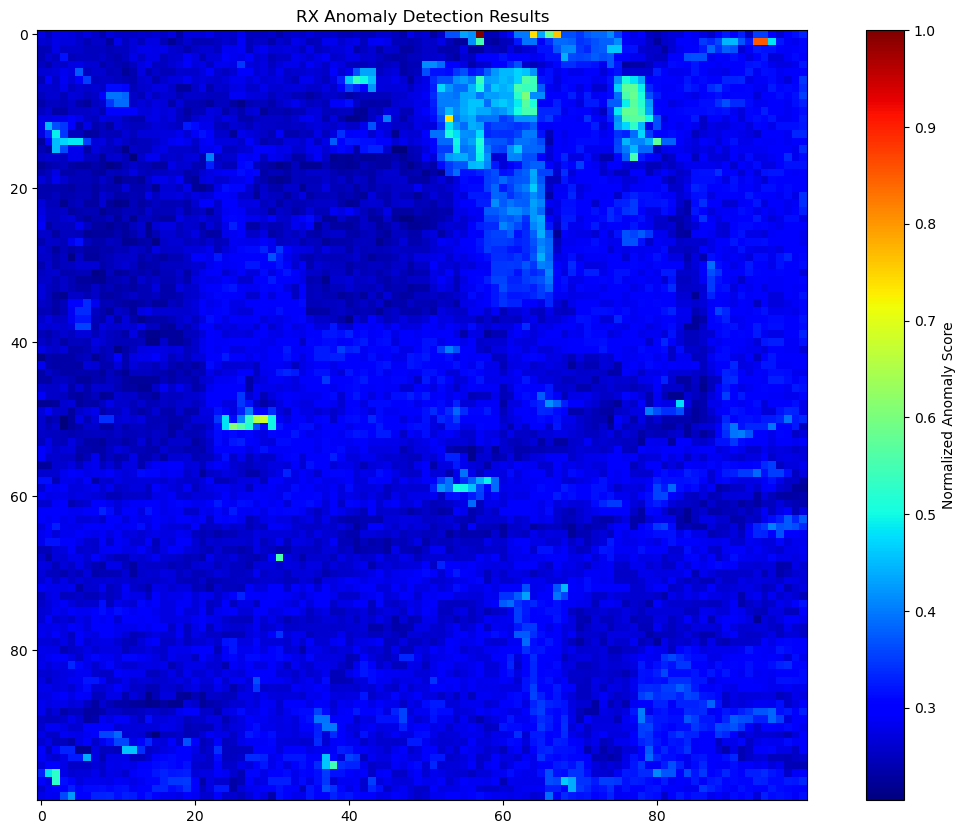

In [26]:
#first working with the abu-airport-1.mat

#rx algorithm implementation:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

def rx_algorithm(file_path, visualize=True):
    """
    Implements the Reed-Xiaoli (RX) algorithm for anomaly detection in hyperspectral images.
    
    Parameters:
    - file_path: str, path to the .mat file containing hyperspectral data.
    - visualize: bool, whether to visualize the anomaly detection results.
    
    Returns:
    - anomaly_scores_normalized: 2D numpy array of normalized anomaly scores.
    """
    #loading the hyperspectral image data
    mat_data= loadmat(file_path)
    hyperspectral_data= mat_data['data']
    
    #reshape data to 2D (pixels x bands)
    data_reshaped= hyperspectral_data.reshape(-1, hyperspectral_data.shape[2])
    
    #calculating global mean and covariance
    global_mean= np.mean(data_reshaped, axis=0)
    global_covariance= np.cov(data_reshaped, rowvar=False)
    covariance_inverse= np.linalg.inv(global_covariance)
    
    #computing Mahalanobis distance for each pixel
    diff= data_reshaped - global_mean
    anomaly_scores= np.sqrt(np.sum(diff @ covariance_inverse * diff, axis=1))
    
    #reshape anomaly scores to original spatial dimensions and normalize
    anomaly_scores_image = anomaly_scores.reshape(hyperspectral_data.shape[:2])
    anomaly_scores_normalized = anomaly_scores_image / np.max(anomaly_scores_image)
    
    if visualize:
        #visualizing the normalized anomaly scores
        plt.figure(figsize=(15, 10))
        plt.imshow(anomaly_scores_normalized, cmap='jet', interpolation='nearest')
        plt.colorbar(label='Normalized Anomaly Score')
        plt.title('RX Anomaly Detection Results')
        plt.show()
    
    return anomaly_scores_normalized

file_path= 'abu-airport-1.mat'
normalized_anomaly_scores= rx_algorithm(file_path, visualize=True)

In [27]:
normalized_anomaly_scores

array([[0.27469681, 0.24842431, 0.27329304, ..., 0.30107291, 0.31525787,
        0.33054759],
       [0.26509432, 0.25906925, 0.2768392 , ..., 0.29131688, 0.2822274 ,
        0.30782564],
       [0.24274504, 0.2452141 , 0.27879729, ..., 0.29086577, 0.29556751,
        0.30798066],
       ...,
       [0.2942607 , 0.27576817, 0.52703938, ..., 0.32322511, 0.32030232,
        0.33208807],
       [0.26243947, 0.28624824, 0.29616648, ..., 0.30819064, 0.30147341,
        0.30681804],
       [0.2762851 , 0.28624824, 0.28243847, ..., 0.31205148, 0.29039216,
        0.31425057]])

In [28]:
normalized_anomaly_scores.shape

(100, 100)

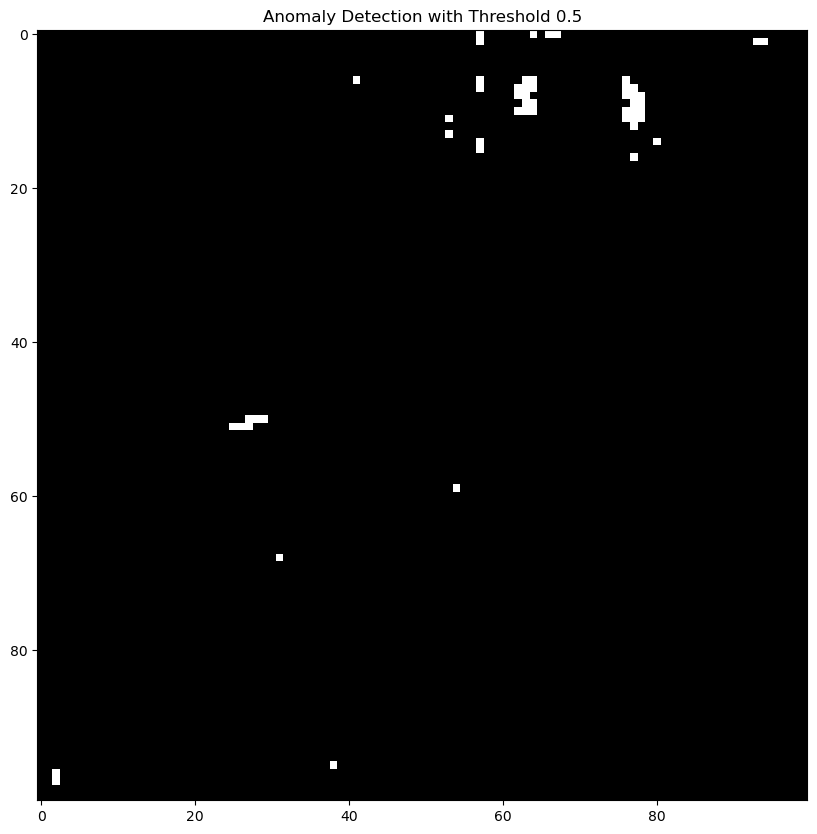

In [74]:
#implementing simple thresholding with the threshold value set as 0.5

def simple_thresholding(anomaly_scores, threshold):
    """
    Applies simple thresholding to anomaly scores and visualizes the result in a binary manner.
    
    Parameters:
    - anomaly_scores: 2D numpy array, normalized anomaly scores for each pixel.
    - threshold: float, the threshold value for classifying anomalies.
    
    The function will plot the thresholded anomaly detection result, where pixels with scores
    above the threshold are brightened (indicating potential anomalies), and others are darkened.
    """
    #applying the threshold
    binary_classification= anomaly_scores > threshold
    
    #visualizing the result
    plt.figure(figsize=(15, 10))
    plt.imshow(binary_classification, cmap='gray')
    plt.title(f'Anomaly Detection with Threshold {threshold}')
    plt.show()


smp_thr= simple_thresholding(normalized_anomaly_scores, threshold=0.5)

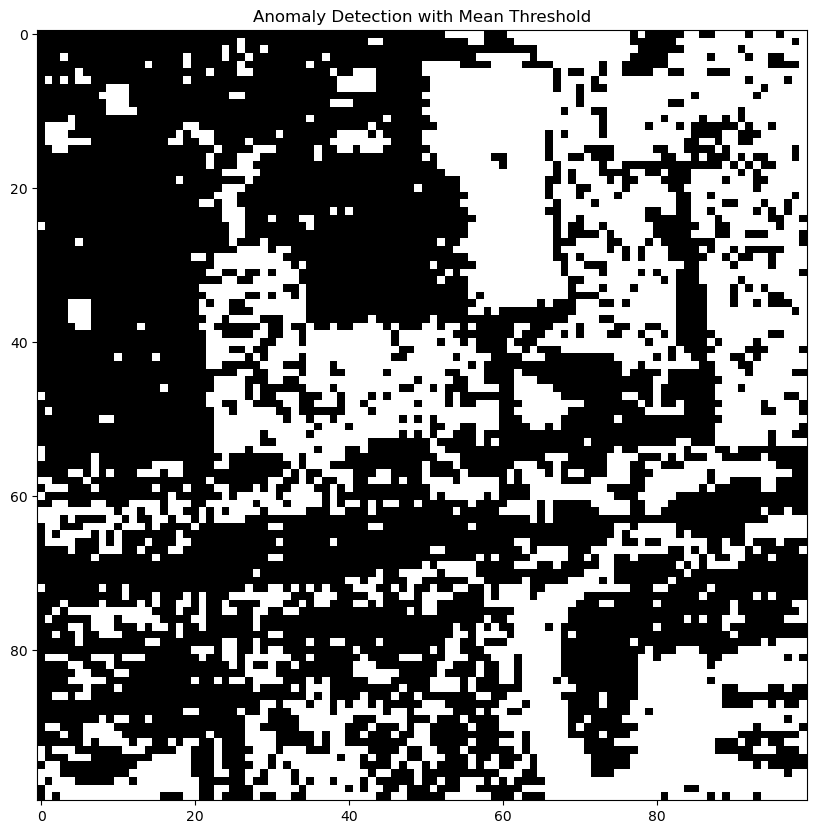

In [31]:
#implementing mean thresholding:
def mean_thresholding(anomaly_scores):
    """
    Applies thresholding based on the mean value of anomaly scores and visualizes the result.
    
    Parameters:
    - anomaly_scores: 2D numpy array, normalized anomaly scores for each pixel.
    
    Visualizes the thresholded anomaly detection result where pixels with scores above the mean are highlighted.
    """
    #calcing the mean threshold
    mean_threshold= np.mean(anomaly_scores)
    
    #applying threshold
    binary_classification= anomaly_scores > mean_threshold
    
    #visualizing the result
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_classification, cmap='gray')
    plt.title(f'Anomaly Detection with Mean Threshold')
    plt.show()
    
    return mean_threshold

mean_thr= mean_thresholding(normalized_anomaly_scores)

In [32]:
mean_thr

0.28491409190823214

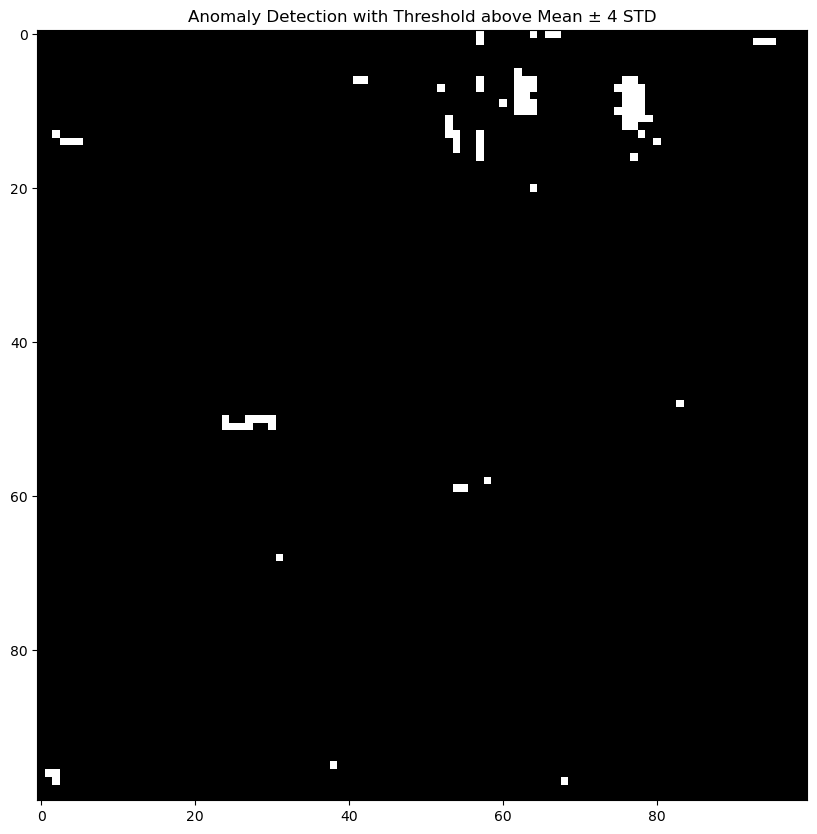

'\nAbove>> Mean+Standard Deviation: by setting the threshold above mean by certain number of std dev, we can focus on identifying most extreme anomalies.\nThis reduces the likelihood of false positives but can miss subtle anomalies.\nthis case is ideal when we want highly confident anomalies to be detected, wherein the cost of investigating false positives is high.\n\nBelow>> Mean-Standard Deviatio: by setting this, it makes the detection makes more sensitive, can potentially identify the more subtle anomalies.\nThis can increase the number of detecting false positives.\nthis is useful in cases where missing an anomaly can have serious consequences, even if we detect more false positives.\n'

In [110]:
#implmenting thresholding using standard deviation:
def std_dev_thresholding(anomaly_scores, num_std_dev, direction='above'):
    """
    Applies thresholding based on the mean anomaly score plus/minus standard deviations and visualizes the result.
    
    Parameters:
    - anomaly_scores: 2D numpy array, normalized anomaly scores for each pixel.
    - num_std_dev: int or float, number of standard deviations to adjust the threshold.
    - direction: str, 'above' to add or 'below' to subtract the standard deviations from the mean.
    
    Visualizes the thresholded anomaly detection result, highlighting potential anomalies.
    """
    mean_value= np.mean(anomaly_scores)
    std_dev_value= np.std(anomaly_scores)
    
    if direction== 'above':
        threshold= mean_value + (num_std_dev * std_dev_value)
    else:
        threshold= mean_value - (num_std_dev * std_dev_value)
    
    #applying threshold
    binary_classification = anomaly_scores > threshold
    
    #visualizing the result
    plt.figure(figsize=(15, 10))
    plt.imshow(binary_classification, cmap='gray')
    plt.title(f'Anomaly Detection with Threshold {direction} Mean ± {num_std_dev} STD')
    plt.show()
    
    return mean_value, std_dev_value

std_dev_thr= std_dev_thresholding(normalized_anomaly_scores, num_std_dev=4, direction='above')

"""
Above>> Mean+Standard Deviation: by setting the threshold above mean by certain number of std dev, we can focus on identifying most extreme anomalies.
This reduces the likelihood of false positives but can miss subtle anomalies.
this case is ideal when we want highly confident anomalies to be detected, wherein the cost of investigating false positives is high.

Below>> Mean-Standard Deviatio: by setting this, it makes the detection makes more sensitive, can potentially identify the more subtle anomalies.
This can increase the number of detecting false positives.
this is useful in cases where missing an anomaly can have serious consequences, even if we detect more false positives.
"""

No knee point was found or the knee index is not an integer.


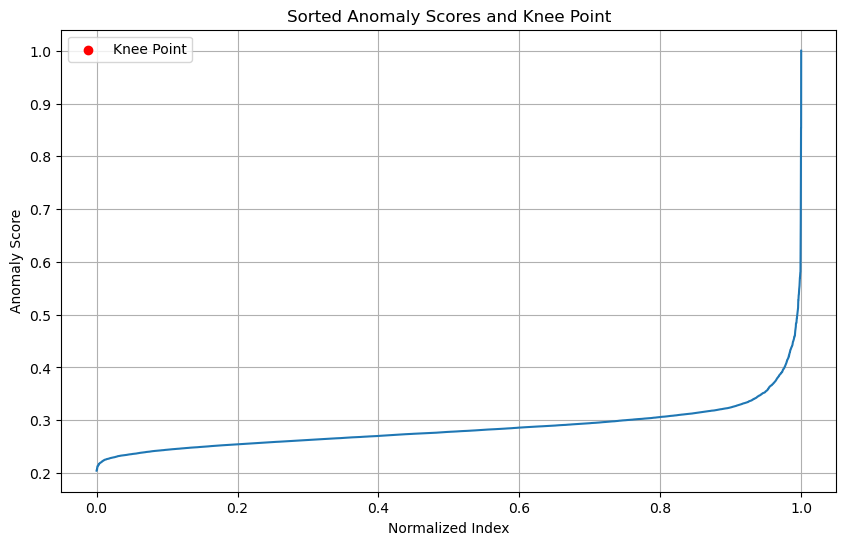

The knee point value for anomalies is: None


In [49]:
#implementing using knee point detection
def find_knee_point(anomaly_scores):
    """
    Flattens the 2D array of anomaly scores into a 1D array, sorts it, finds the knee point,
    and plots the results with the knee point highlighted.
    
    Parameters:
    - anomaly_scores: 2D numpy array of normalized anomaly scores.
    
    Returns:
    - knee_value: The anomaly score at the knee point, potentially indicating the threshold for anomalies.
    """
    #flattening the 2D array into 1D
    scores_flat= anomaly_scores.flatten()
    
    #sorting the scores in ascending order
    scores_sorted= np.sort(scores_flat)
    
    #normalizing the index to match the range of scores for the KneeLocator
    normalized_index= np.arange(len(scores_sorted)) / len(scores_sorted)
    
    #using KneeLocator to find the knee point in the curve
    knee_locator= KneeLocator(normalized_index, scores_sorted, curve='concave', direction='increasing')
    
    #checking if knee point was found
    if knee_locator.knee is None or not np.issubdtype(type(knee_locator.knee), np.integer):
        print("No knee point was found or the knee index is not an integer.")
        knee_value= None
    else:
        #finding knee point in terms of anomaly score
        knee_value= scores_sorted[knee_locator.knee]
    
    #plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(normalized_index, scores_sorted)
    plt.xlabel('Normalized Index')
    plt.ylabel('Anomaly Score')
    plt.title('Sorted Anomaly Scores and Knee Point')
    
    #highlighting the knee point
    plt.scatter(knee_locator.knee, knee_value, color='red', label='Knee Point', zorder=5)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return knee_value

knee_point= find_knee_point(normalized_anomaly_scores)
print("The knee point value for anomalies is:", knee_point)

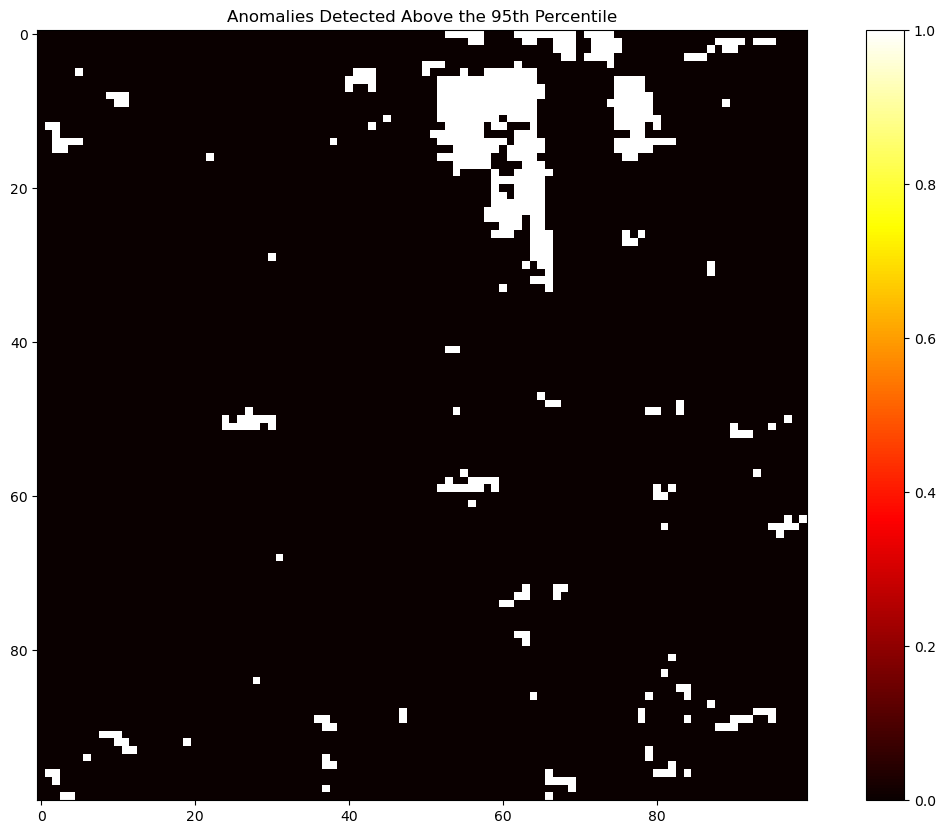

In [95]:
def apply_percentile_thresholding_95(anomaly_scores, percentile):
    """
    Applies percentile-based thresholding to normalized anomaly scores and visualizes the anomalies.
    
    Parameters:
    - anomaly_scores_normalized: 2D numpy array of normalized anomaly scores.
    - percentile: int, the percentile to use for identifying anomalies.
    
    Returns:
    - binary_anomaly_map: 2D boolean numpy array, where True indicates an anomaly.
    """
    #calcing the threshold value at the given percentile
    threshold= np.percentile(anomaly_scores, percentile)
    
    #creating a binary map where True indicates pixels with scores above the threshold
    binary_anomaly_map= anomaly_scores> threshold
    
    #visualizing the binary anomaly map
    plt.figure(figsize=(15, 10))
    plt.imshow(binary_anomaly_map, cmap='hot')
    plt.title(f'Anomalies Detected Above the {percentile}th Percentile')
    plt.colorbar()
    plt.show()
    
    return binary_anomaly_map

anomalies_map1= apply_percentile_thresholding_95(normalized_anomaly_scores, percentile=95)

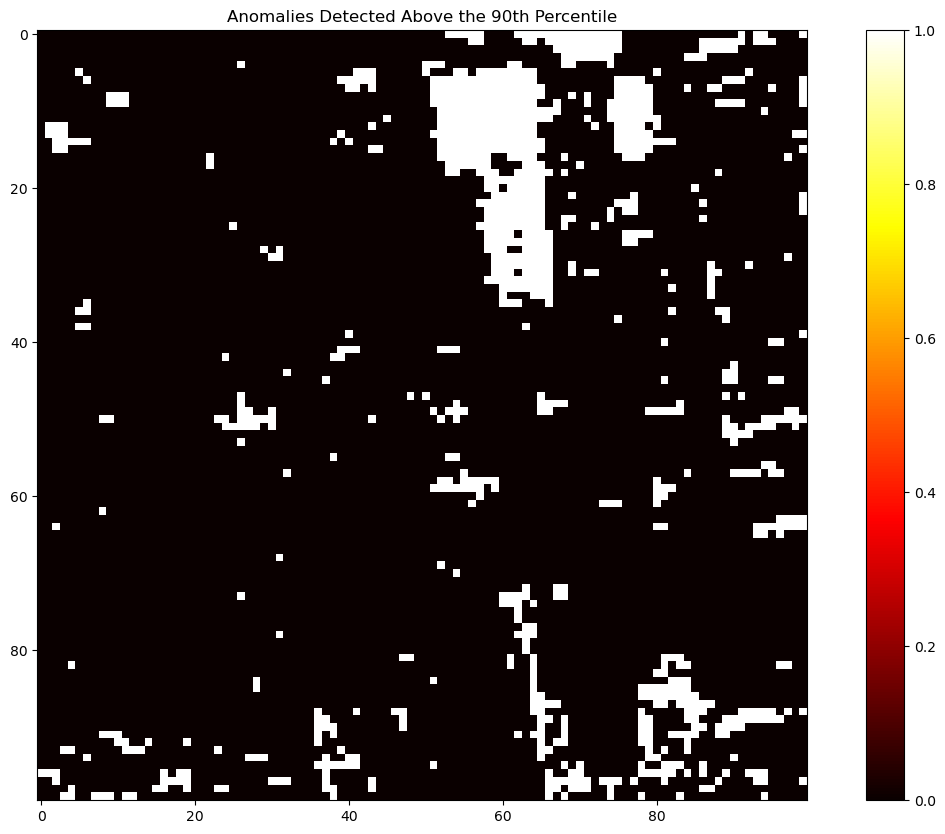

In [93]:
def apply_percentile_thresholding_90(anomaly_scores, percentile):
    """
    Applies percentile-based thresholding to normalized anomaly scores and visualizes the anomalies.
    
    Parameters:
    - anomaly_scores_normalized: 2D numpy array of normalized anomaly scores.
    - percentile: int, the percentile to use for identifying anomalies.
    
    Returns:
    - binary_anomaly_map: 2D boolean numpy array, where True indicates an anomaly.
    """
    #calcing the threshold value at the given percentile
    threshold= np.percentile(anomaly_scores, percentile)
    
    #creating a binary map where True indicates pixels with scores above the threshold
    binary_anomaly_map= anomaly_scores> threshold
    
    #visualizing the binary anomaly map
    plt.figure(figsize=(15, 10))
    plt.imshow(binary_anomaly_map, cmap='hot')
    plt.title(f'Anomalies Detected Above the {percentile}th Percentile')
    plt.colorbar()
    plt.show()
    
    return binary_anomaly_map

anomalies_map1_2= apply_percentile_thresholding_90(normalized_anomaly_scores, percentile=90)

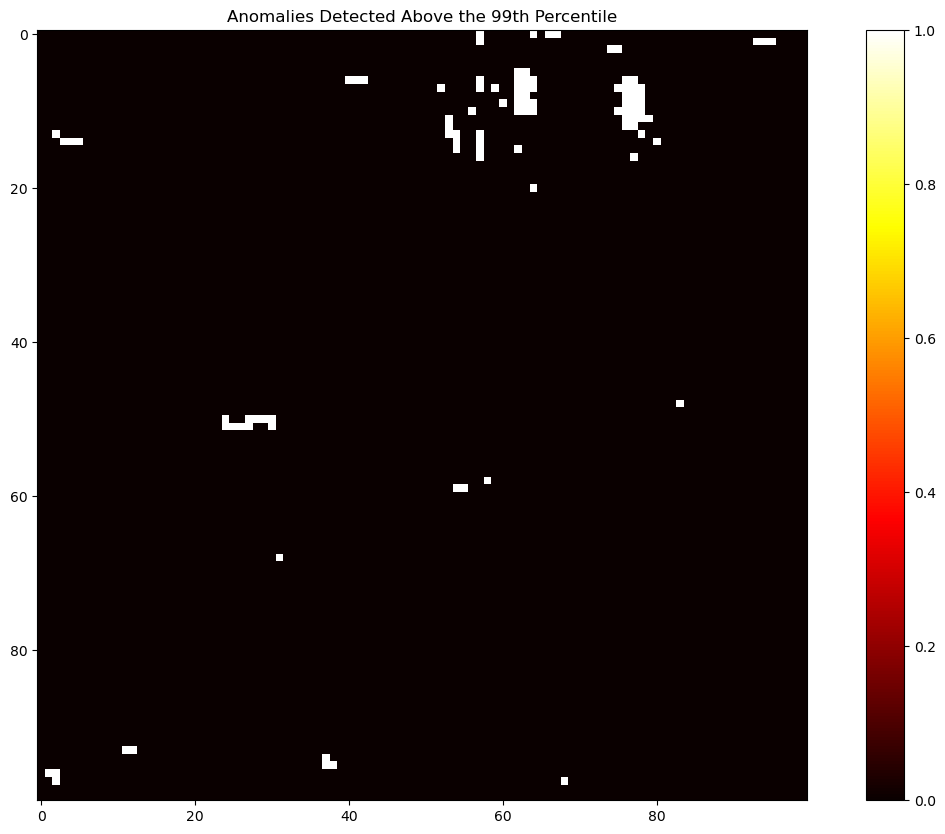

In [97]:
def apply_percentile_thresholding_99(anomaly_scores, percentile):
    """
    Applies percentile-based thresholding to normalized anomaly scores and visualizes the anomalies.
    
    Parameters:
    - anomaly_scores_normalized: 2D numpy array of normalized anomaly scores.
    - percentile: int, the percentile to use for identifying anomalies.
    
    Returns:
    - binary_anomaly_map: 2D boolean numpy array, where True indicates an anomaly.
    """
    #calcing the threshold value at the given percentile
    threshold= np.percentile(anomaly_scores, percentile)
    
    #creating a binary map where True indicates pixels with scores above the threshold
    binary_anomaly_map= anomaly_scores> threshold
    
    #visualizing the binary anomaly map
    plt.figure(figsize=(15, 10))
    plt.imshow(binary_anomaly_map, cmap='hot')
    plt.title(f'Anomalies Detected Above the {percentile}th Percentile')
    plt.colorbar()
    plt.show()
    
    return binary_anomaly_map

anomalies_map1_3= apply_percentile_thresholding_99(normalized_anomaly_scores, percentile=99)

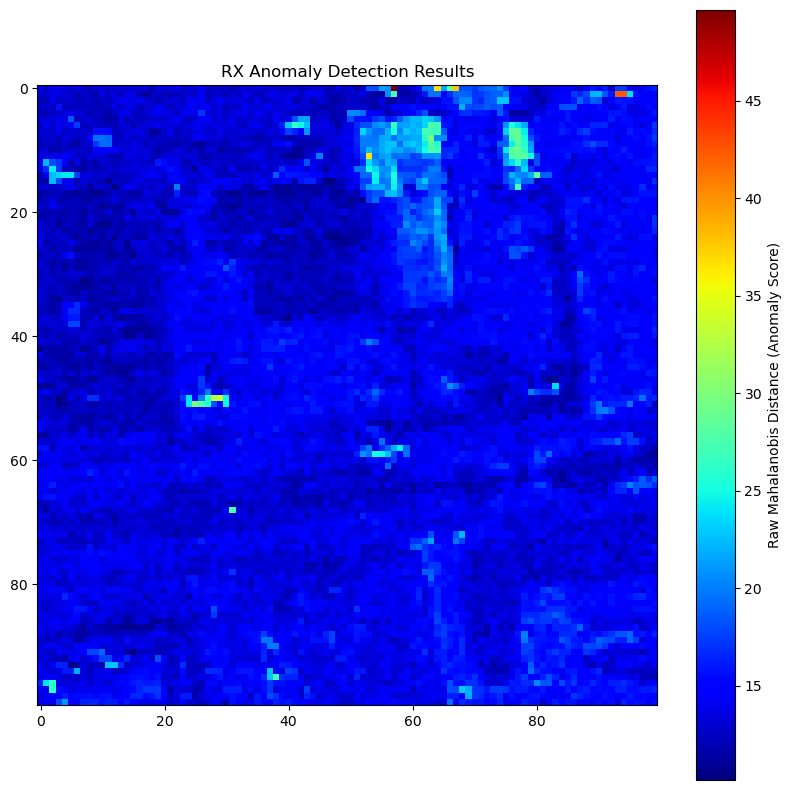

In [67]:
#using raw mahalanobis distance and not normalizing the anomaly scores, for comparison purposes..

from scipy.linalg import inv
from scipy.spatial.distance import mahalanobis

def parallel_compute_mahalanobis(pixel, global_mean, inv_covmat):
    """
    Computing the Mahalanobis distance for a single pixel in parallel.
    """
    return mahalanobis(pixel, global_mean, inv_covmat)

def rx_algo_with_joblib(file_path, visualize=True, n_jobs=-1):
    """
    Implements the RX algorithm for anomaly detection in hyperspectral images using parallel processing.
    
    Parameters:
    - file_path: str, path to the .mat file containing hyperspectral data.
    - visualize: bool, whether to visualize the anomaly detection results.
    - n_jobs: int, the number of parallel jobs to run. -1 means using all processors.
    
    Returns:
    - anomaly_scores: 2D numpy array of raw Mahalanobis distances (anomaly scores).
    """
    #loading the hyperspectral image data
    mat_data= loadmat(file_path)
    hyperspectral_data= mat_data['data']
    
    #reshaping data to 2D>>pixels x bands
    data_reshaped= hyperspectral_data.reshape(-1, hyperspectral_data.shape[2])
    
    #calcing global mean and covariance matrix
    global_mean= np.mean(data_reshaped, axis=0)
    global_covariance= np.cov(data_reshaped, rowvar=False)
    covariance_inverse= inv(global_covariance)
    
    #computing Mahalanobis distance for each pixel using parallel processing
    anomaly_scores= Parallel(n_jobs=n_jobs)(delayed(parallel_compute_mahalanobis)(pixel, global_mean, covariance_inverse) for pixel in data_reshaped)
    
    #reshape anomaly scores to original spatial dimensions
    anomaly_scores_img= np.array(anomaly_scores).reshape(hyperspectral_data.shape[:2])
    
    if visualize:
        #viz the anomaly scores
        plt.figure(figsize=(10, 10))
        plt.imshow(anomaly_scores_img, cmap='jet', interpolation='nearest')
        plt.colorbar(label='Raw Mahalanobis Distance (Anomaly Score)')
        plt.title('RX Anomaly Detection Results')
        plt.show()
    
    return anomaly_scores_img

anomaly_scores_2= rx_algo_with_joblib(file_path, visualize=True, n_jobs=-1)

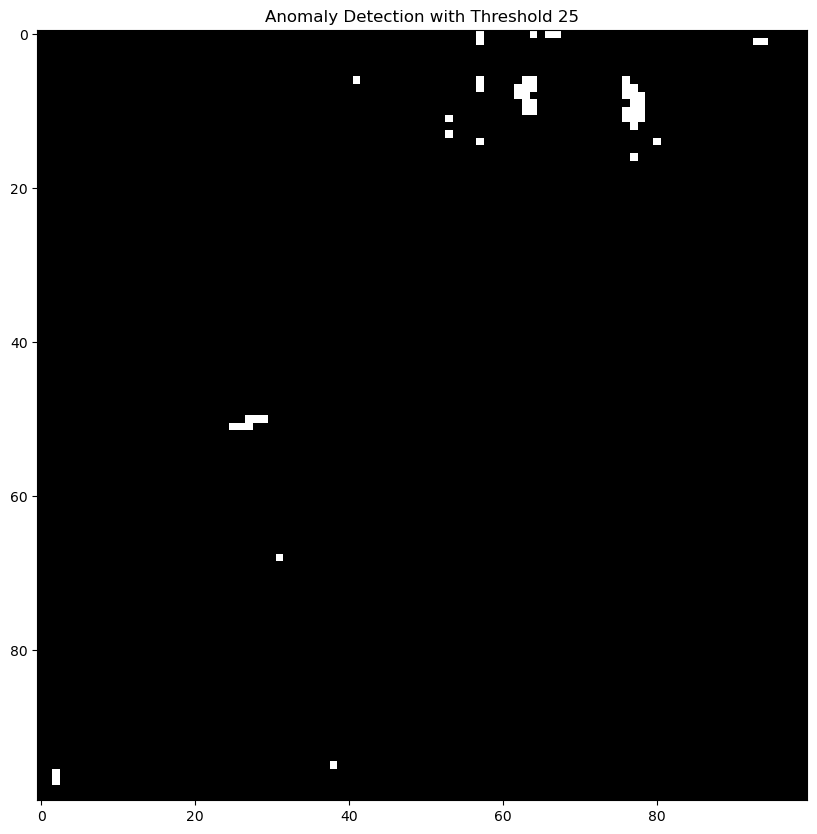

In [83]:
#calling the  previously made thresholding functions again...
smp_thr2= simple_thresholding(anomaly_scores_2, threshold=25)

In [70]:
anomaly_scores_2

array([[13.64080499, 12.33617394, 13.57109702, ..., 14.95058105,
        15.6549731 , 16.41422504],
       [13.1639677 , 12.86477683, 13.74719105, ..., 14.46611926,
        14.01475697, 15.28590607],
       [12.05415466, 12.17676207, 13.84442566, ..., 14.44371838,
        14.67719564, 15.29360389],
       ...,
       [14.61230269, 13.69400646, 26.17155083, ..., 16.05060763,
        15.90546868, 16.49072157],
       [13.0321343 , 14.2144221 , 14.70693929, ..., 15.30403075,
        14.97046878, 15.23587059],
       [13.71967588, 14.2144221 , 14.02523792, ..., 15.49575141,
        14.42019974, 15.60495279]])

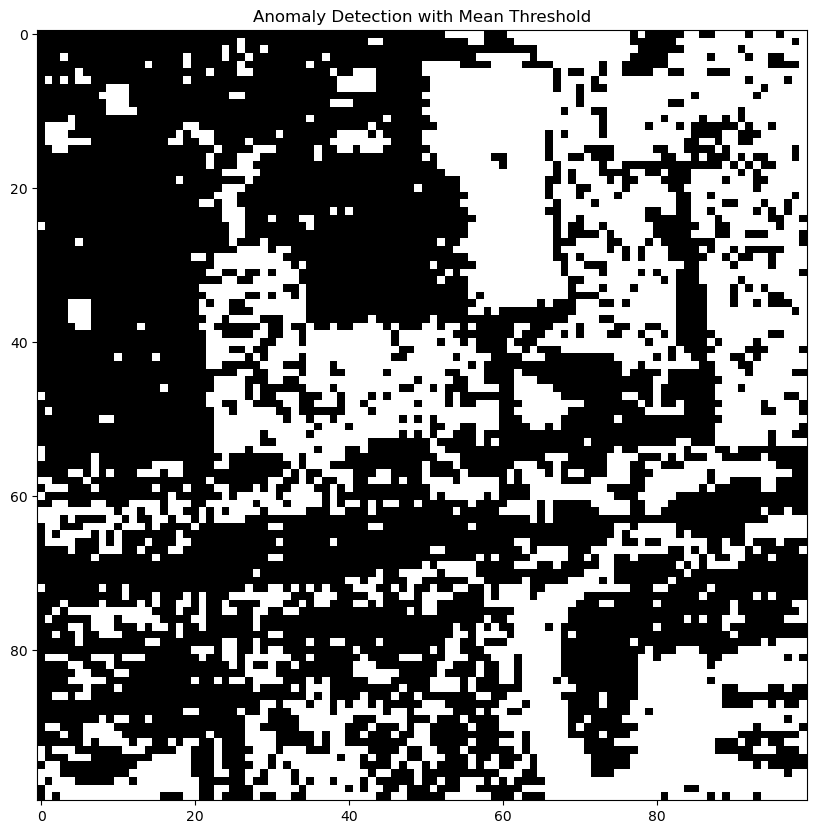

In [85]:
mean_thr2= mean_thresholding(anomaly_scores_2)

In [86]:
mean_thr2

14.148171633143205

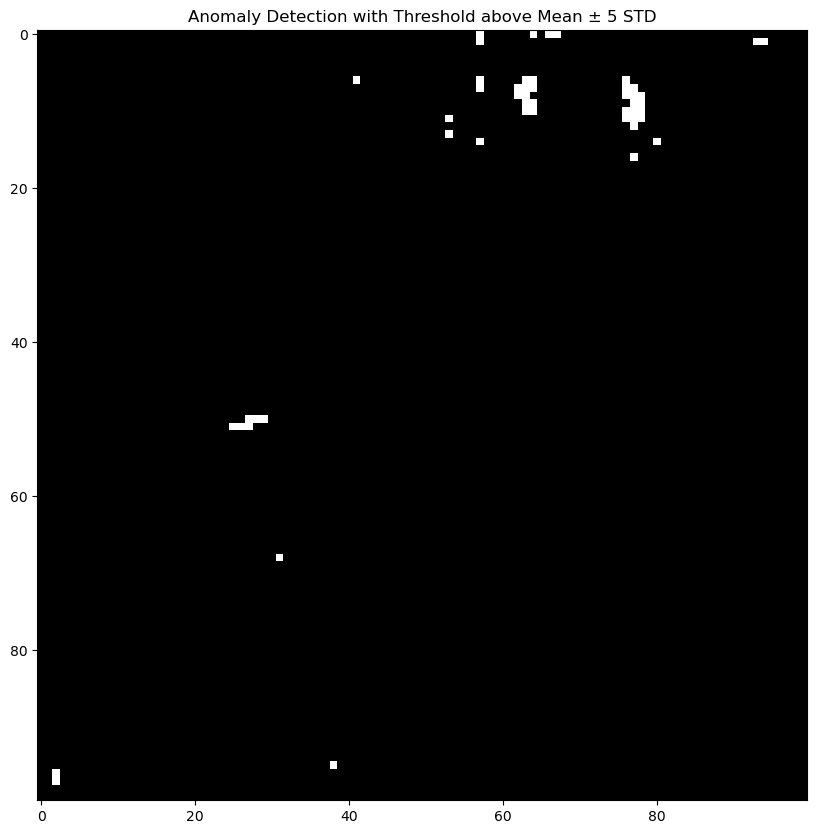

In [88]:
std_dev_thr2= std_dev_thresholding(anomaly_scores_2, num_std_dev=5, direction='above')

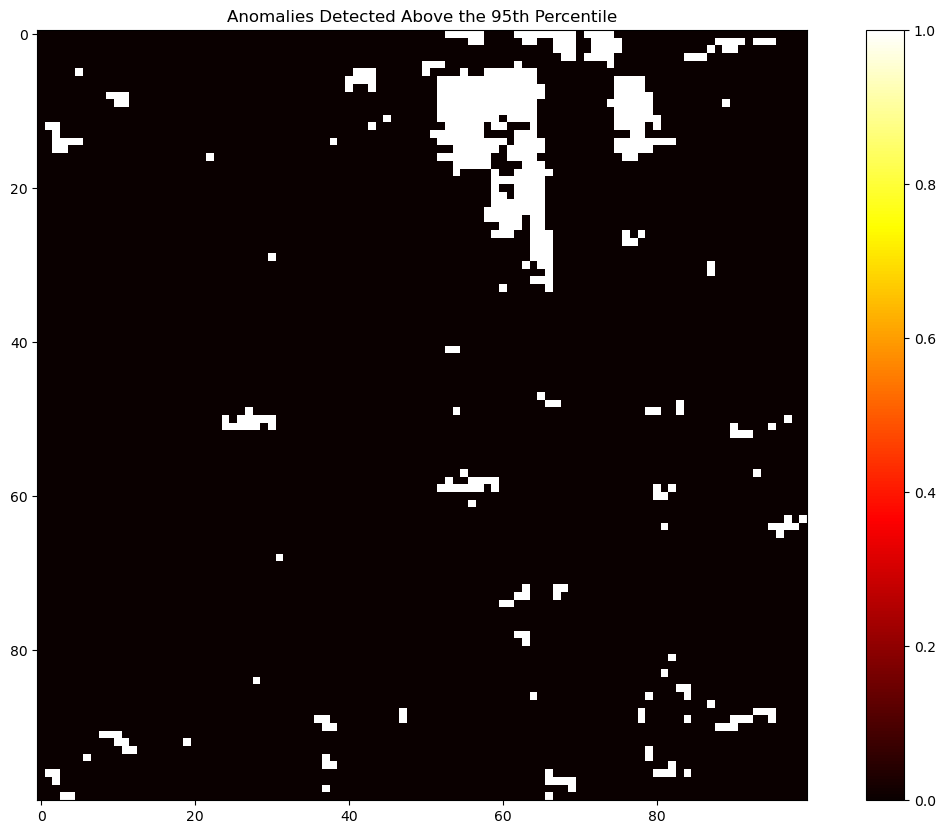

In [92]:
anomalies_map2_1= apply_percentile_thresholding_95(anomaly_scores_2, percentile=95)

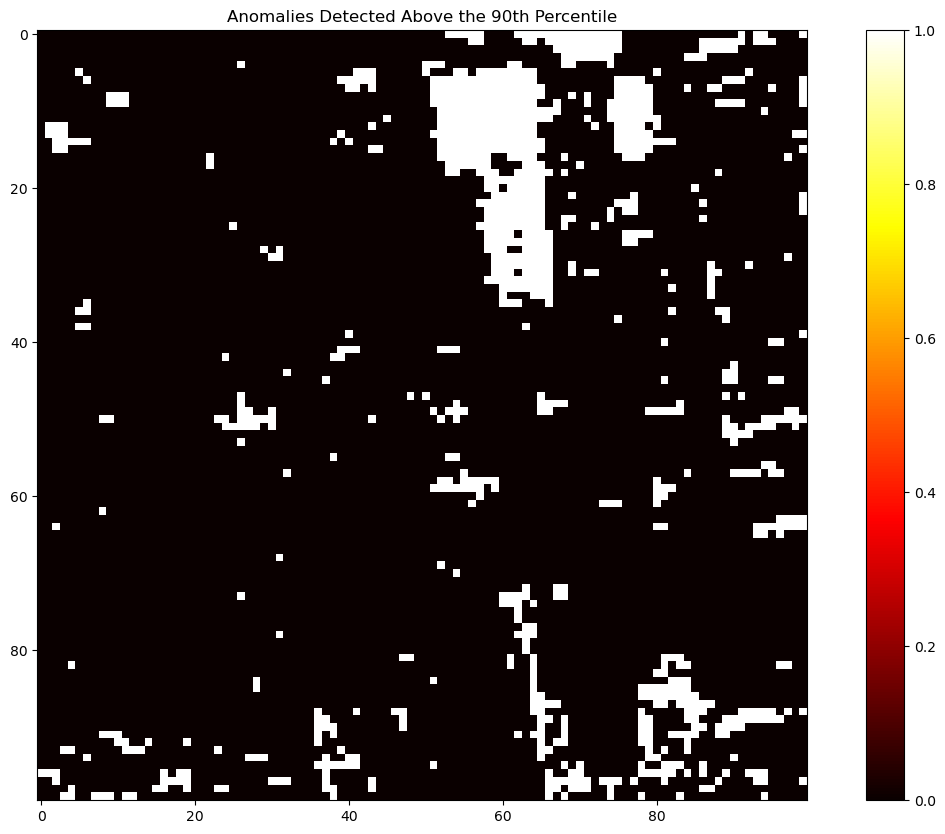

In [96]:
anomalies_map2_2= apply_percentile_thresholding_90(anomaly_scores_2, percentile=90)

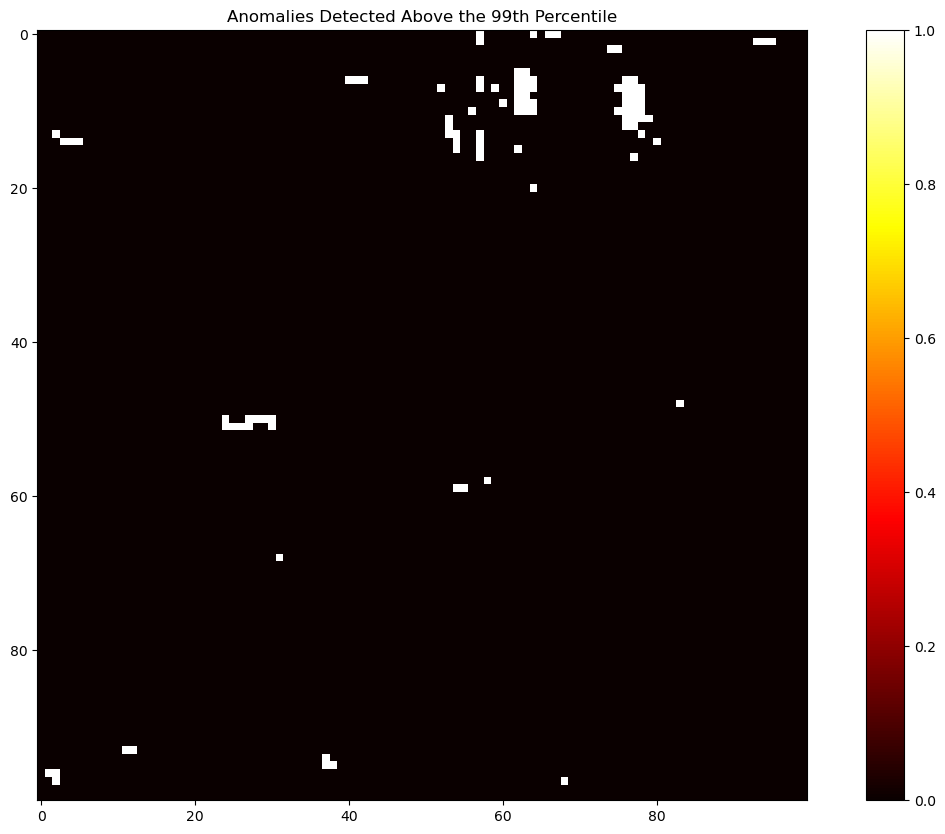

In [98]:
anomalies_map2_3= apply_percentile_thresholding_99(anomaly_scores_2, percentile=99)

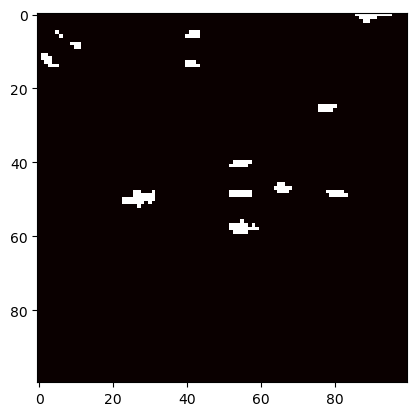

In [101]:
#plotting with the ground truth first:
mat_data= loadmat(file_path)

plt.imshow(mat_data['map'], cmap= 'hot')
plt.show()

In [103]:
#converting the anomaly data to binary format:
anomaly_actual= mat_data['map']

bin_anomaly_actual= (anomaly_actual>0).astype(int)

In [104]:
bin_anomaly_actual.shape

(100, 100)

In [117]:
bin_anomaly_actual

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [111]:
binary_pred_map1= anomalies_map1_3

In [112]:
binary_pred_map1.shape

(100, 100)

In [116]:
binary_pred_map1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [113]:
binary_pred_map2= anomalies_map2_3

In [115]:
binary_pred_map2.shape

(100, 100)

In [118]:
#converting boolean arrays to integer arrays
binary_pred_map1_int= binary_pred_map1.astype(int)
binary_pred_map2_int= binary_pred_map2.astype(int)

In [119]:
binary_pred_map1_int

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [121]:
from sklearn.metrics import accuracy_score, f1_score

def calculate_performance_metrics(actual, predictions):
    """
    Calculates and prints the accuracy and F1-score for the given actual and predicted binary maps.

    Parameters:
    - actual: 2D numpy array, the actual ground truth binary map.
    - predictions: 2D numpy array, the predicted binary map.
    """
    #flattening the 2D arrays to 1D
    actual_flat= actual.flatten()
    predictions_flat= predictions.flatten()

    #calcing accuracy
    accuracy= accuracy_score(actual_flat, predictions_flat)

    #calcing F1-score
    f1= f1_score(actual_flat, predictions_flat)

    #returning the performance metrics
    return accuracy, f1

#calcing performance metrics for each prediction map
accuracy1, f1_score1= calculate_performance_metrics(bin_anomaly_actual, binary_pred_map1_int)
accuracy2, f1_score2= calculate_performance_metrics(bin_anomaly_actual, binary_pred_map2_int)

#calcing performance metrics
print(f"Accuracy for binary_pred_map1_int: {accuracy1:.8f}")
print(f"F1-Score for binary_pred_map1_int: {f1_score1:.8f}")
print(f"Accuracy for binary_pred_map2_int: {accuracy2:.8f}")
print(f"F1-Score for binary_pred_map2_int: {f1_score2:.8f}")

Accuracy for binary_pred_map1_int: 0.97960000
F1-Score for binary_pred_map1_int: 0.16393443
Accuracy for binary_pred_map2_int: 0.97960000
F1-Score for binary_pred_map2_int: 0.16393443


In [125]:
from sklearn.metrics import roc_auc_score

auc_roc= roc_auc_score(bin_anomaly_actual.flatten(), binary_pred_map1_int.flatten())
print(f"AUC-ROC for binary_pred_map1_int: {auc_roc:.5f}")

auc_roc= roc_auc_score(bin_anomaly_actual.flatten(), binary_pred_map2_int.flatten())
print(f"AUC-ROC for binary_pred_map2_int: {auc_roc:.5f}")

AUC-ROC for binary_pred_map1_int: 0.56539
AUC-ROC for binary_pred_map2_int: 0.56539


## Graph Based Anomaly Detection

In [126]:
import networkx as nx
from scipy.spatial.distance import euclidean

In [127]:
#using mat_data here also

hyperspectral_dt= mat_data['data']

#graph construction

#initialzing the graph
G= nx.Graph()

#parameters for graph construction
height, width, _= hyperspectral_dt.shape

#adding nodes
for y in range(height):
    for x in range(width):
        node_id= (y, x)
        spectral_data= hyperspectral_dt[y, x, :]
        G.add_node(node_id, spectral_data=spectral_data)
        


#adding edges based on spectral similarity (euclidean distance)
for y in range(height):
    for x in range(width):
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]: #4 connectivity
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width:
                node_id = (y, x)
                neighbor_id = (ny, nx)
                #using euclidean distance for measuring spectral similarity
                weight = euclidean(G.nodes[node_id]['spectral_data'], G.nodes[neighbor_id]['spectral_data'])
                G.add_edge(node_id, neighbor_id, weight=weight)    

In [162]:
#calcing spectral deviation and anomaly detection:

def detect_anomalies(G, deviation_threshold, degree_threshold):
    """
    Detect anomalies in a graph based on spectral deviation and connectivity.
    
    Parameters:
    - G: The graph of nodes and edges, with nodes having 'spectral_data'.
    - deviation_threshold: Threshold for spectral deviation to consider a node an anomaly.
    - degree_threshold: Threshold for node degree below which a node is considered an anomaly.
    
    Returns:
    - anomalies: A list of node identifiers marked as anomalies.
    """
    anomalies= []
    for node in G.nodes():
        neighbors= list(G.neighbors(node))
        if not neighbors:  #if node has no neighbors, consider isolation criteria
            continue
        
        #calculating spectral deviation
        node_spectrum= G.nodes[node]['spectral_data']
        neighbor_spectra= np.array([G.nodes[neighbor]['spectral_data'] for neighbor in neighbors])
        avg_neighbor_spectrum= np.mean(neighbor_spectra, axis=0)
        deviation= np.linalg.norm(node_spectrum - avg_neighbor_spectrum)
        
        #node degree (connectivity)
        degree= G.degree(node)
        
        #anomaly detection based on deviation and degree
        if deviation> deviation_threshold and degree< degree_threshold:
            anomalies.append(node)
    
    return anomalies

#G is the graph made from the hhyperspectral data
dev_threshold= 890  #can be adjusted; increased from taking from 10 with about 396 anomalies and remains same till 50
deg_threshold= 4   #can be adjusted
anomalies= detect_anomalies(G, dev_threshold, deg_threshold)
print(f"Detecting {len(anomalies)} anomalies.")

Detecting 144 anomalies.


In [163]:
#converting detected anomalies to a binary map
anomaly_map= np.zeros((height, width), dtype=int)
for (y, x) in anomalies:
    anomaly_map[y, x]= 1
    
anomaly_map_flat= anomaly_map.flatten()

In [164]:
#taking the 'map' values and adding them to the graph created

anomaly_truth= mat_data['map']

#updating the graph
for y in range(height):
    for x in range(width):
        node_id= (y, x)
        spectral_data= hyperspectral_dt[y, x, :]
        is_anom= anomaly_truth[y, x] > 0  #anomalies are marked with values > 0
        G.add_node(node_id, spectral_data=spectral_data, is_anom=is_anom)

In [165]:
#converting the anomaly truth to binary format
anomaly_grd_truth= (anomaly_truth>0).astype(int)

#flattening it
anomaly_truth_flat= anomaly_grd_truth.flatten()

In [166]:
#counting actual num of anomalies in the ground truth
actual_anomalies_count= np.sum(anomaly_grd_truth)

#similarly we can also use this
#actual_anomalies_count_flat= np.sum(anomaly_truth_flat)

print(f"Actual number of anomalous pixels in the ground truth: {actual_anomalies_count}")

Actual number of anomalous pixels in the ground truth: 144


In [167]:
from sklearn.metrics import precision_score, recall_score
#calculating metrics
acc= accuracy_score(anomaly_truth_flat, anomaly_map_flat)
precision= precision_score(anomaly_truth_flat, anomaly_map_flat)
recall= recall_score(anomaly_truth_flat, anomaly_map_flat)
f1= f1_score(anomaly_truth_flat, anomaly_map_flat)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9730
Precision: 0.0625
Recall: 0.0625
F1-Score: 0.0625


1. Accuracy>>0.9628 or 96.28%<< indicates the proportion of true results both true positives and true negatives, among the total number of cases examined. High accuracy is generally desirable, when dealing with imbalanced datasets where one class significantly outnumbers the other, it can be misleading. In the context of anomaly detection, where anomalies (positives) are often much rarer than normal (negative) instances, high accuracy might not fully reflect the effectiveness of the anomaly detection.

2. Precision >>0.0403 or 4.03%<< measures the accuracy of positive preds. indicates that only 4.03% of the pixels predicted as anomalies were actual anomalies according to the ground truth. Low precision suggests a high number of false positives (normal pixels incorrectly labeled as anomalies).

3. Recall >>0.0694 or 6.94%<< measures the ability of the model to find all the actual positives (anomalies). A recall of 6.94% means that the model detected only a small fraction of the actual anomalies.

4. F1-Score >>0.0510 or 5.10%<< is the harmonic mean of precision and recall. provides a single metric that balances both precision and recall, which is particularly useful in situations of imbalanced classes. A low F1-score indicates that the model is neither precise nor robust in detecting anomalies.

highly imbalanced dataset... has relatively small num of actual anomalies compared to normal instances...
this implementation works well when the individual doing this has domain knowledge..

In [168]:
df3= pd.read_csv('hyperspectral_combined_data.csv')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 206 entries, Band_1 to Label
dtypes: int64(206)
memory usage: 15.7 MB


# Implementing PCA

In [179]:
import scipy.io
import os

def convert_mat_files_to_csv(mat_file_path):
    
    mat_data= scipy.io.loadmat(mat_file_path)
    data= mat_data['data'].reshape(-1, mat_data['data'].shape[2]) 
    
    
    labels= mat_data['map'].flatten()
    
    #generating column names for bands
    headers= [f'Band_{i+1}' for i in range(data.shape[1])] + ['Label']
    
    #ensuring labels array matches the number of rows in your data
    if len(labels)!= data.shape[0]:
        raise ValueError("Mismatch in the number of pixels and labels.")
    df= pd.DataFrame(data)
    df['Label'] = labels[:data.shape[0]] 
    return df
    
    

mat_file_paths= ['abu-airport-1.mat', 'abu-airport-2.mat', 'abu-airport-3.mat', 'abu-airport-4.mat',
                'abu-beach-1.mat', 'abu-beach-2.mat', 'abu-beach-3.mat', 'abu-beach-4.mat',
                'abu-urban-1.mat', 'abu-urban-2.mat', 'abu-urban-3.mat', 'abu-urban-4.mat', 'abu-urban-5.mat']

df_list= [convert_mat_files_to_csv(file_path) for file_path in mat_file_paths]
combined_df1= pd.concat(df_list, ignore_index=True)

combined_csv_path= 'com_hyperspectral2_data.csv'
combined_df1.to_csv(combined_csv_path, index=False)

In [178]:
#for ease of computation I'm working on the hyperspectral_combined.csv created in the starting...

# Ending it here for the meantime, because of time constraints, hopefully the primary objectives that were achieved suffice.